In [27]:
import os
import glob
import numpy as np
import rasterio
import matplotlib.pyplot as plt


In [28]:
features = "data/cloud_data/train_features"
labels   = "data/cloud_data/train_labels"

chips = sorted([d for d in os.listdir(features) if os.path.isdir(os.path.join(features, d))])

print("Total chips ", len(chips))
print("Example chip ", chips[0])


Total chips  50
Example chip  alpj


In [29]:
def load_chip(chip_id):
    chip_path = os.path.join(features, chip_id)
    band_files = sorted(glob.glob(f"{chip_path}/*.tif"))
    
    bands = []
    for f in band_files:
        with rasterio.open(f) as src:
            bands.append(src.read(1).astype(np.float32))
    img = np.stack(bands, axis=0)
    
    label_path = os.path.join(labels, chip_id + ".tif")
    with rasterio.open(label_path) as src:
        mask = src.read(1).astype(np.uint8)
    
    if img.max() > 1.5:
        img /= 10000.0
    
    return img, mask

In [30]:
chip_id = chips[0]
img, mask = load_chip(chip_id)

In [31]:
print("Image shape ", img.shape)
print("Mask shape ", mask.shape)

Image shape  (4, 512, 512)
Mask shape  (512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


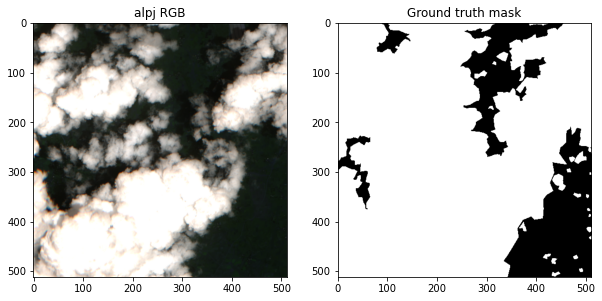

In [34]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(np.transpose(img[:3], (1,2,0)))

plt.title(f"{chip_id} RGB")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Ground truth mask")

plt.show()